In [17]:
from explainers.GNNBoundary.gnn_boundary.models.gcn_classifier import GCNClassifier as GCNClassifier
import torch as torch

In [15]:

model = GCNClassifier(num_layers=3, num_classes=4, node_features=3, hidden_channels=32)
model.load_state_dict(torch.load('model/report_models/multi_grids.pt'))

<All keys matched successfully>

In [66]:
from graph_generation.MultiGraphs import MultiGraphs
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(MultiGraphs(10000, negative_class=True).getDataset())
mean_embeds = dataset.mean_embeddings(model)

In [108]:
from explainers.gnninterpreter import *
c = 0

trainer = {}
trainer[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=25,
                num_node_cls=3,
                temperature=0.15,
                learn_node_feat=True
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=50),
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=3, mode='minimize'), weight=50),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=5),
                dict(key="logits", criterion=MeanPenalty(), weight=0),
                dict(key="omega", criterion=NormPenalty(order=1), weight=1),
                dict(key="omega", criterion=NormPenalty(order=2), weight=1),
                dict(key="xi", criterion=NormPenalty(order=1), weight=0),
                dict(key="xi", criterion=NormPenalty(order=2), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=16
        )

In [109]:
trainer[0].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=2 m=1
logits=[-53.25527572631836, 5.894179821014404, -49.68318557739258, -24.452192306518555]
probs=[2.049829023643951e-26, 1.0, 7.295527153408791e-25, 6.618168605374355e-14]


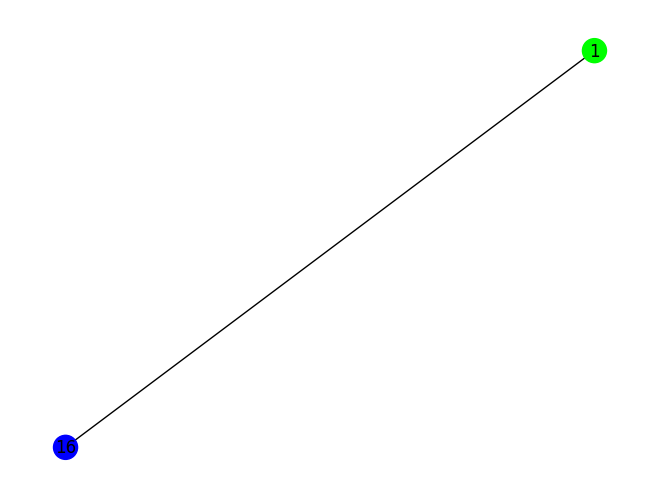

(<networkx.classes.graph.Graph at 0x7f7c08bbf370>,
 {'n': 2,
  'm': 1,
  'logits': [-53.25527572631836,
   5.894179821014404,
   -49.68318557739258,
   -24.452192306518555],
  'probs': [2.049829023643951e-26,
   1.0,
   7.295527153408791e-25,
   6.618168605374355e-14]})

In [103]:
trainer[1].evaluate(threshold=0.5, show=True)

n=4 m=2
logits=[0.008008599281311035, -18.132083892822266, -9.280320167541504, -12.58416748046875]
probs=[0.9999040365219116, 1.3237809071142692e-08, 9.248860442312434e-05, 3.3981737033172976e-06]


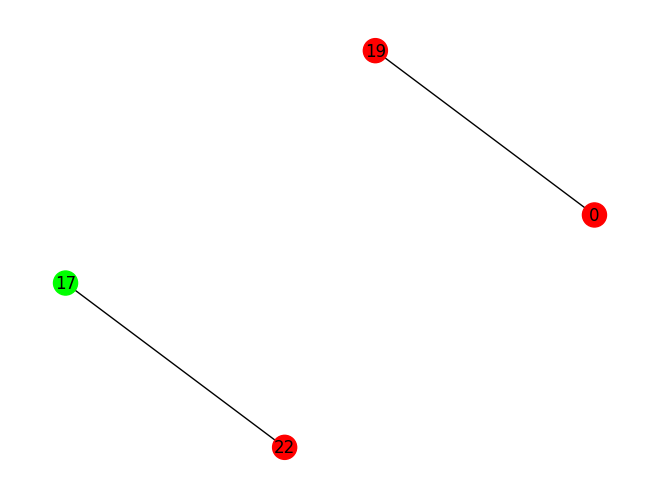

(<networkx.classes.graph.Graph at 0x7f7c029ecf70>,
 {'n': 4,
  'm': 2,
  'logits': [0.008008599281311035,
   -18.132083892822266,
   -9.280320167541504,
   -12.58416748046875],
  'probs': [0.9999040365219116,
   1.3237809071142692e-08,
   9.248860442312434e-05,
   3.3981737033172976e-06]})

In [110]:
trainer[0].evaluate(threshold=0.5, show=True)